In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load libraries

In [86]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix

import tensorflow as tf
tf.random.set_seed(0)
tf.keras.backend.clear_session

<function tensorflow.python.keras.backend.clear_session()>

# Load data

In [87]:
path = '/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/'
tdat = pd.read_csv(path+'icml_face_data.csv')
tdat.sample(5)

,emotion,Usage,pixels
33603,4,PrivateTest,8 19 40 61 88 105 115 130 141 149 156 164 172 ...
5285,2,Training,210 211 213 215 219 216 208 209 154 165 202 19...
17221,3,Training,205 179 210 186 61 148 185 160 186 179 167 213...
19206,3,Training,148 161 255 226 54 49 36 184 255 255 197 255 2...
23395,2,Training,252 252 252 252 252 250 255 142 56 58 48 53 52...


In [88]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Preprocess data

In [89]:
tdat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [90]:
dat = tdat.copy()
dat.drop_duplicates(inplace=True)
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34653 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  34653 non-null  int64 
 1    Usage   34653 non-null  object
 2    pixels  34653 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [91]:
dat[' Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

[Text(0, 0, 'Angry'),
 Text(1, 0, 'Disgust'),
 Text(2, 0, 'Fear'),
 Text(3, 0, 'Happy'),
 Text(4, 0, 'Sad'),
 Text(5, 0, 'Surprise'),
 Text(6, 0, 'Neutral')]

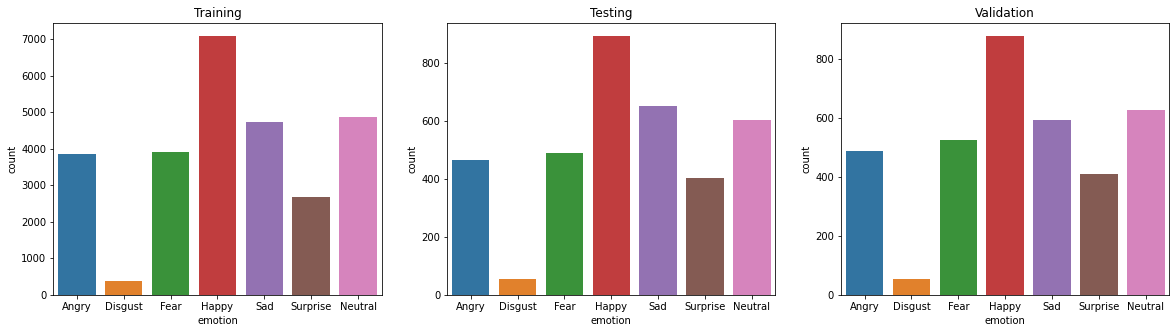

In [92]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
sns.countplot(data = dat[dat[' Usage']=='Training'], x='emotion', ax=ax1).set_title('Training')
ax1.set_xticklabels(emotions.values())
sns.countplot(data = dat[dat[' Usage']=='PublicTest'], x='emotion', ax=ax2).set_title('Testing')
ax2.set_xticklabels(emotions.values())
sns.countplot(data = dat[dat[' Usage']=='PrivateTest'], x='emotion', ax=ax3).set_title('Validation')
ax3.set_xticklabels(emotions.values())

# Helper functions

In [93]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

  
def sample_plot(x,y=None):
    #x, y are numpy arrays
    n = 20
    samples = random.sample(range(x.shape[0]),n)
    
    fig, axs = plt.subplots(2,10, figsize=(25,5), sharex=True, sharey=True)
    ax = axs.ravel()
    for i in range(n):
        ax[i].imshow(x[samples[i],:,:], cmap=plt.get_cmap('gray'))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        if y is not None:
            ax[i].set_title(emotions[y[samples[i]]])

# Prepare data for CNN

In [94]:
train_image_array, train_image_label = prepare_data(dat[dat[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(dat[dat[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(dat[dat[' Usage']=='PublicTest'])

train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')

train_labels = tf.keras.utils.to_categorical(train_image_label)
val_labels = tf.keras.utils.to_categorical(val_image_label)
test_labels = tf.keras.utils.to_categorical(test_image_label)

# Sample and visualize images from train/valid/test data sets

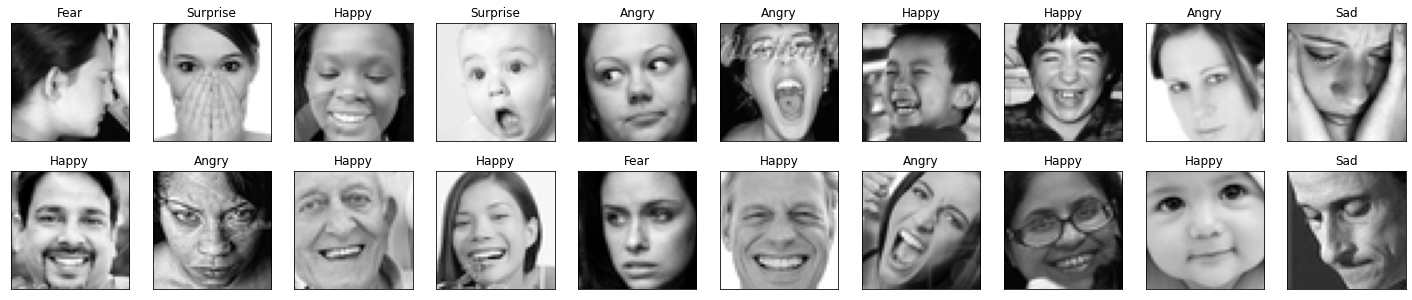

In [95]:
sample_plot(train_image_array, train_image_label)

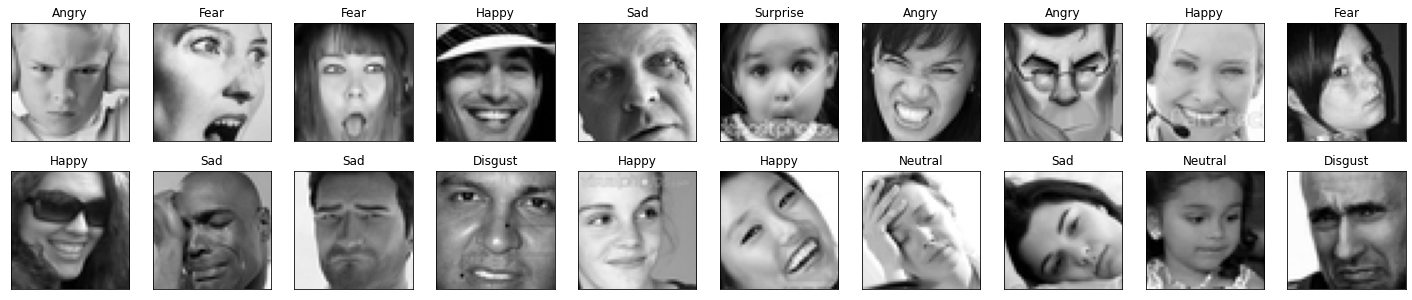

In [96]:
sample_plot(val_image_array, val_image_label)

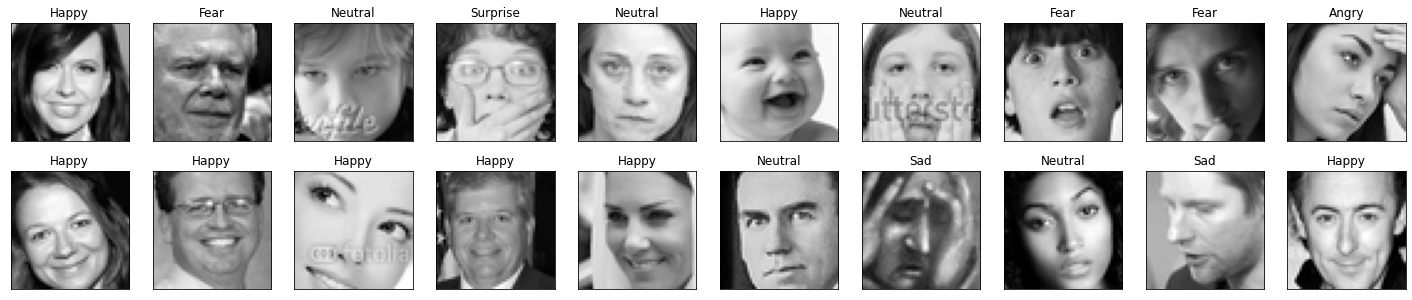

In [97]:
sample_plot(test_image_array, test_image_label)

# CNN

In [98]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(48,48,1)),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor = 0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
    
    tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(16,5,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2),
    
    tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(emotions), activation='softmax'),    
])

In [99]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

earlystop = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=1e-3, restore_best_weights=True)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-7)

In [100]:
wt = dat[dat[' Usage']=="Training"].groupby('emotion').agg('count')
# class_weights = 
wt['fraction'] = wt[' pixels']/np.sum(wt[' pixels'])
class_weights = dict(zip(range(7), wt.fraction))

In [101]:
hist = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=50,
                    class_weight=class_weights,
                    batch_size=128,
                    callbacks=[earlystop, lr])

Epoch 1/50
215/215 [==============================] - 9s 37ms/step - loss: 0.3020 - accuracy: 0.2838 - val_loss: 1.9428 - val_accuracy: 0.3002
Epoch 2/50
215/215 [==============================] - 8s 36ms/step - loss: 0.2420 - accuracy: 0.3949 - val_loss: 1.9649 - val_accuracy: 0.3442
Epoch 3/50
215/215 [==============================] - 8s 36ms/step - loss: 0.2228 - accuracy: 0.4391 - val_loss: 1.6717 - val_accuracy: 0.4362
Epoch 4/50
215/215 [==============================] - 8s 35ms/step - loss: 0.2081 - accuracy: 0.4809 - val_loss: 1.4478 - val_accuracy: 0.4818
Epoch 5/50
215/215 [==============================] - 8s 36ms/step - loss: 0.1976 - accuracy: 0.5098 - val_loss: 1.3177 - val_accuracy: 0.5145
Epoch 6/50
215/215 [==============================] - 8s 36ms/step - loss: 0.1881 - accuracy: 0.5314 - val_loss: 1.3305 - val_accuracy: 0.5154
Epoch 7/50
215/215 [==============================] - 8s 35ms/step - loss: 0.1794 - accuracy: 0.5518 - val_loss: 1.3175 - val_accuracy: 0.5151

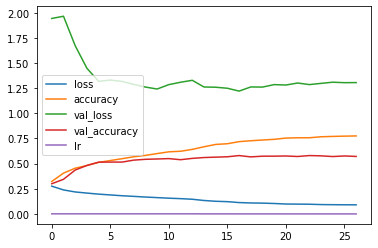

In [102]:
for key in hist.history.keys():
    plt.plot(hist.history[key], label=key)
plt.legend()

In [103]:
model.evaluate(test_images, test_labels)
test_pred = model.predict(test_images)
confusion_matrix(y_true=test_image_label, y_pred=np.argmax(test_pred,axis=1))

112/112 [==============================] - 1s 8ms/step - loss: 1.2888 - accuracy: 0.5671


array([[210,   0,  41,  42,  83,  14,  74],
       [ 25,   0,  12,   6,   7,   1,   4],
       [ 49,   0, 149,  38, 135,  48,  72],
       [ 27,   0,  14, 750,  34,  13,  56],
       [ 71,   0,  60,  72, 302,  13, 134],
       [ 14,   0,  27,  34,  20, 279,  29],
       [ 36,   0,  33,  74, 123,   8, 331]])